In [10]:
import math, pickle, glob
import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from numpy import format_float_scientific

#matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.linewidth'] = 0.8
saveformat = 'eps' # or ''
dpi = 1200

## FINEtune

10
28
[2154.434690031883, 1357.2088082974526, 1035.7441686512857, 854.9879733383482, 736.8062997280771, 652.4779401948103, 588.7550428297936, 538.6086725079707, 497.9338607285737, 464.15888336127773]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


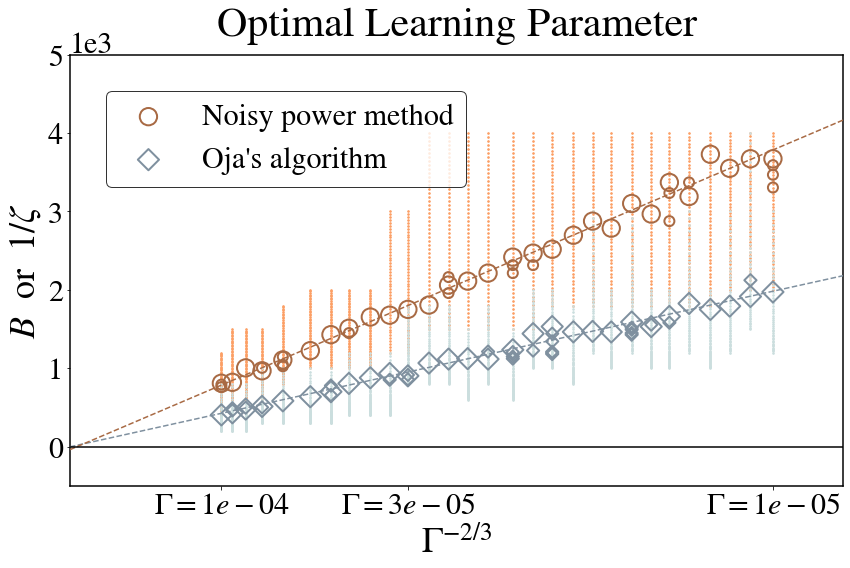

In [36]:
pattern = 'finetune' # or ''

npm_color = (0.65882337, 0.41664   , 0.26533333, 1.        )
npm_cand_color = (0.98823506, 0.62496   , 0.398     , 1.        )

oja_color = (0.49754902, 0.56433819, 0.62254893, 1.        )
oja_cand_color = (0.79626218, 0.86960784, 0.86960781, 1.        )

debug = False
candidates = True
paramtitle = False
axvline = False
suboptima = True

gammathres = 0.000003
poweredgammathres = 13.5

ss = 100
linewidth = 2

figlabel = 'optimal_lp{}{}.{}'.format(pattern,'_withcand' if candidates else '',saveformat)

fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1))

oja_x,     oja_y = [], []
noisy_x, noisy_y = [], []
inverse = 1
######################################################################################
wild_dir = './finetuned/noisy/noisy_{}*/*'.format(pattern)

list_for_lpwise_dicts = []

path_list = glob.glob(wild_dir+'*.pickle')
for path in path_list:
    with open(path, 'rb') as f:
        hyperdict  = pickle.load(f)
        lpwise_dict = pickle.load(f)
    gamma = hyperdict['gamma']
    if (gamma < gammathres):
        continue
    
    list_for_lpwise_dicts.append((gamma, lpwise_dict, hyperdict['lp_list']))    
    
list_for_lpwise_dicts = sorted(list_for_lpwise_dicts, key=lambda x: float(x[0]))

algo = hyperdict['algo']
T, T_save, loop, k, p = hyperdict['T'], hyperdict['T_save'] ,hyperdict['loop'], hyperdict['k'], hyperdict['p']
sigma, delta = hyperdict['sigma'], hyperdict['delta']
learning_param_list = hyperdict['lp_list']

print(loop)

#######################################################################################

for c, (gamma, datadict_list, lp_list) in enumerate(list_for_lpwise_dicts):

    dist_array = np.zeros((loop,len(lp_list)))
    
    for idx,datadict in enumerate(datadict_list):

        for jdx,lp in enumerate(lp_list):
            dist_array[idx,jdx] = np.average(datadict[lp][-10:])
            
    lp_list = np.power(np.asarray(lp_list,dtype=np.float64),1 * inverse)
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    best_lp = lp_list[np.argmin(avg)]
    poweredgamma = pow(gamma,-2/3 * inverse)
    noisy_x.append(poweredgamma)
    noisy_y.append(best_lp)
    
    if suboptima:
        bestidx = np.argmin(avg)
        best_lps = lp_list[avg[bestidx]+std[bestidx] > avg+std]
        plt.scatter([poweredgamma]*len(best_lps),best_lps,marker='o',s=ss,zorder=3,color='None',edgecolors=npm_color,linewidth=linewidth)
        
    if candidates:
        plt.scatter([poweredgamma]*len(lp_list), lp_list,marker='.',s=10,color=npm_cand_color )
    
#######################################################################################

wild_dir = './finetuned/oja/oja_{}*/*'.format(pattern)

list_for_lpwise_dicts = []

path_list = glob.glob(wild_dir+'*.pickle')
for path in path_list:
    with open(path, 'rb') as f:
        hyperdict  = pickle.load(f)
        lpwise_dict = pickle.load(f)
    gamma = hyperdict['gamma']
    if (gamma < gammathres):
        continue
        
    list_for_lpwise_dicts.append((gamma, lpwise_dict, hyperdict['lp_list']))    
    
list_for_lpwise_dicts = sorted(list_for_lpwise_dicts, key=lambda x: float(x[0]))

algo = hyperdict['algo']
T, T_save, loop, k, p = hyperdict['T'], hyperdict['T_save'] ,hyperdict['loop'], hyperdict['k'], hyperdict['p']
sigma, delta = hyperdict['sigma'], hyperdict['delta']
learning_param_list = hyperdict['lp_list']

#######################################################################################

for c, (gamma, datadict_list, lp_list) in enumerate(list_for_lpwise_dicts):

    dist_array = np.zeros((loop,len(lp_list)))
    
    for idx,datadict in enumerate(datadict_list):

        for jdx,lp in enumerate(lp_list):
            dist_array[idx,jdx] = np.average(datadict[lp][-100:])
    
    lp_list = np.power(lp_list,-1 * inverse)
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    best_lp = lp_list[np.argmin(avg)]
    poweredgamma = pow(gamma,-2/3 * inverse)
    oja_x.append(poweredgamma)
    oja_y.append(best_lp)
    
    if suboptima:
        bestidx = np.argmin(avg)
        best_lps = lp_list[avg[bestidx]+std[bestidx] > avg+std]
        #plt.scatter([poweredgamma]*len(best_lps),best_lps,marker='x',s=ss,zorder=3,color=oja_color,linewidth=1.5)
        plt.scatter([poweredgamma]*len(best_lps),best_lps,marker='D',s=ss*0.75,zorder=3,color='None',edgecolors=oja_color,linewidth=linewidth)
    
    if candidates:
        plt.scatter([poweredgamma]*len(lp_list), lp_list,marker='.',s=10,color=oja_cand_color )
    
    if debug:
        plt.text(poweredgamma,poweredgamma*25,'{:.5f}'.format(gamma))
    
#######################################################################################
regressidxs = np.where(np.asarray(oja_x) > poweredgammathres)[0][-1]
print(regressidxs)

oja_slope, oja_intercept,_,_,_ = linregress(oja_x[:regressidxs+1],oja_y[:regressidxs+1])
noisy_slope, noisy_intercept,_,_,_ = linregress(noisy_x[:regressidxs+1],noisy_y[:regressidxs+1])

regress_x = np.linspace(0,1.1*pow(10,10/3),250)
plt.plot(regress_x, regress_x * oja_slope + oja_intercept, '--', linewidth = 1.5, color=oja_color,zorder=4)
plt.plot(regress_x, regress_x * noisy_slope + noisy_intercept, '--', linewidth = 1.5, color=npm_color,zorder=4)

plt.scatter(noisy_x,noisy_y,marker='o',s=ss*3,zorder=1,color='None',edgecolors=npm_color,linewidth=linewidth,label='Noisy power method')
#plt.scatter(oja_x,oja_y,marker='x',s=ss*4,zorder=1,color=oja_color,linewidth=1.5,label='Oja\'s algorithm')
plt.scatter(oja_x,oja_y,marker='D',s=ss*2.25,zorder=1,color='None',edgecolors=oja_color,linewidth=linewidth,label='Oja\'s algorithm')

# figure settings
if paramtitle:
    title = r'Optimal Learning Parameter, $(\delta,\,\sigma,\,p/k)=({:.2f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = 'Optimal Learning Parameter'
    titlesize = 42
plt.title(title,fontsize=titlesize,pad=20)

plt.xlim(0,1.1*pow(10,10/3))

xtickslist = [1.0e-5,3.0e-5,1.0e-4]

print([pow(x,-2/3) for x in np.arange(1.0e-5,1.1e-4,1.0e-5)])

plt.xticks([pow(x,-2/3) for x in xtickslist],[r"$\Gamma={:.0e}$".format(x) for x in xtickslist]) #format_float_scientific(x, exp_digits=1)

plt.ylim(-500,5000)
#plt.yticks([0,1000,2000,3000,4000,5000],["{}".format(x) for x in [0,1000,2000,3000,4000,5000]],fontsize=30)
plt.gca().set_yticks([0,1000.0,2000.0,3000,4000,5000])
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_fontsize(30)
plt.gca().tick_params(axis='both', which='major', labelsize=30)

plt.axhline(y=0, xmin=0 , xmax=1  ,linewidth = 1.5, color='k', linestyle='-',zorder=5)
plt.xlabel(r'$\Gamma^{-2/3}$',fontsize=36,labelpad=5)
plt.ylabel(r'$B$'+'  or  '+r'$1/\zeta$',fontsize=36,labelpad=5)

if axvline:
    fig.legend(loc="upper left",bbox_to_anchor=(0.25,0.85), fontsize=30,frameon=False,ncol=1)
    plt.axvline(x=poweredgammathres, ymin=0 , ymax=1  ,linewidth = 1.0, color='k', linestyle='-.')
else:
    fig.legend(loc="upper left",bbox_to_anchor=(0.11,0.86), fontsize=30,frameon=True,ncol=1,edgecolor='black')  
    
for axis in ['top','bottom','left','right']:
    fig.gca().spines[axis].set_linewidth(1.5)
    
plt.tight_layout()
plt.savefig('../figs/'+figlabel,dpi=dpi)

In [37]:
print(oja_x[-regressN], oja_x[-regressN-1])

NameError: name 'regressN' is not defined